# Rapport de laboratoire 4
Par Hugo Fournier, 2011296

In [1]:
using LinearAlgebra, Krylov, NLPModels, Printf, Logging, SolverCore, Test, ADNLPModels

## Question 1

In [55]:
function gauss_newton(nlp      :: AbstractNLSModel, 
    x        :: AbstractVector, 
    ϵ        :: AbstractFloat;
    η₁       :: AbstractFloat = 1e-3, 
    η₂       :: AbstractFloat = 0.66, 
    σ₁       :: AbstractFloat = 0.25, 
    σ₂       :: AbstractFloat = 2.0,
    max_eval :: Int = 10_000, 
    max_time :: AbstractFloat = 60.,
    max_iter :: Int = typemax(Int64)
    )
######################################################
Fx = residual(nlp, x)
Jx = jac_residual(nlp, x)
######################################################
normFx = norm(Fx)

Δ = 1.

iter = 0    

el_time = 0.0
tired   = neval_residual(nlp) > max_eval || el_time > max_time
status  = :unknown

start_time = time()
too_small  = false
normdual   = norm(Jx' * Fx)
optimal    = min(normFx, normdual) ≤ ϵ

@info log_header([:iter, :nf, :primal, :status, :nd, :Δ],
[Int, Int, Float64, String, Float64, Float64],
hdr_override=Dict(:nf => "#F", :primal => "‖F(x)‖", :nd => "‖d‖"))

while !(optimal || tired || too_small)

#################################
#Compute the a direction satisfying the trust-region constraint
(d, stats)  = lsmr(Jx, -Fx)
#################################

too_small = norm(d) < 1e-15
if too_small #the direction is too small
status = :too_small
else
xp      = x + d
###########################
Fxp     = residual(nlp, xp)
###########################
normFxp = norm(Fxp)

Pred = 0.5 * (normFx^2 - norm(Jx * d + Fx)^2)
Ared = 0.5 * (normFx^2 - normFxp^2)

if Ared/Pred < η₁
Δ = max(1e-8, Δ * σ₁)
status = :reduce_Δ
else #success
x  = xp
###########################
Jx = jac_residual(nlp, x)
###########################
Fx = Fxp
normFx = normFxp
status = :success
if Ared/Pred > η₂ && norm(d) >= 0.99 * Δ
  Δ *= σ₂
end
end
end

@info log_row(Any[iter, neval_residual(nlp), normFx, status, norm(d), Δ])

el_time      = time() - start_time
iter   += 1

many_evals   = neval_residual(nlp) > max_eval
iter_limit   = iter > max_iter
tired        = many_evals || el_time > max_time || iter_limit
normdual     = norm(Jx' * Fx)
optimal      = min(normFx, normdual) ≤ ϵ
end

status = if optimal 
:first_order
elseif tired
if neval_residual(nlp) > max_eval
:max_eval
elseif el_time > max_time
:max_time
elseif iter > max_iter
:max_iter
else
:unknown_tired
end
elseif too_small
:stalled
else
:unknown
end

return GenericExecutionStats(nlp, status = status, solution = x,
               objective = normFx^2 / 2,
               dual_feas = normdual,
               iter = iter,
               elapsed_time = el_time)
end

gauss_newton (generic function with 1 method)

In [71]:
using NLSProblems
nls_model = hs01()
x = 4*rand(nls_model.meta.nvar)

stats = gauss_newton(nls_model, x, 1e-6)
display(stats.solution)

2-element Vector{Float64}:
 1.0000000000007594
 0.9999999999996221

2-element Vector{Float64}:
 -2.0
  1.0

## Question 2

In [3]:
function dsol(Fx, Jx, λ, τ)
    (d, stats) = lsqr(Jx, -Fx, λ = λ, atol = τ)
    return d
end

dsol (generic function with 1 method)

In [4]:
function multi_sol(nlp, x, Fx, Jx, λ, τ; nl = 3)
    (d, stats) = lsqr(Jx, -Fx, λ = λ * 10^((1 - nl) / 2), atol = τ)
    F_best = norm(residual(nlp, x + d))
    d_best = d
    if nl > 1
        for i=2:nl
            (d, stats) = lsqr(Jx, -Fx, λ = λ * 10^(i - (nl + 1) / 2), atol = τ)
            F_norm = norm(residual(nlp, x + d))
            if F_norm < F_best
                F_best = F_norm
                d_best = d
            end
        end
    end
    return d_best
end

multi_sol (generic function with 1 method)

In [56]:
function lm_param(nlp      :: AbstractNLSModel, 
    x        :: AbstractVector, 
    ϵ        :: AbstractFloat;
    η₁       :: AbstractFloat = 1e-3, 
    η₂       :: AbstractFloat = 0.66, 
    σ₁       :: AbstractFloat = 10.0, 
    σ₂       :: AbstractFloat = 0.5,
    max_eval :: Int = 10_000, 
    max_time :: AbstractFloat = 60.,
    max_iter :: Int = typemax(Int64)
    )
######################################################
Fx = residual(nlp, x)
Jx = jac_residual(nlp, x)
######################################################
normFx   = norm(Fx)
normdual = norm(Jx' * Fx)

iter = 0    
λ = 0.0
λ₀ = 1e-6
η = 0.5
τ = η * normdual

el_time = 0.0
tired   = neval_residual(nlp) > max_eval || el_time > max_time
status  = :unknown

start_time = time()
too_small  = false
optimal    = min(normFx, normdual) ≤ ϵ

@info log_header([:iter, :nf, :primal, :status, :nd, :λ],
[Int, Int, Float64, String, Float64, Float64],
hdr_override=Dict(:nf => "#F", :primal => "‖F(x)‖", :nd => "‖d‖"))

while !(optimal || tired || too_small)

###########################
# (d, stats)  = lsqr(Jx, -Fx, λ = λ, atol = τ)
d = multi_sol(nlp, x, Fx, Jx, λ, τ)
###########################

too_small = norm(d) < 1e-16
if too_small #the direction is too small
status = :too_small
else
xp      = x + d
###########################
Fxp     = residual(nlp, xp)
###########################
normFxp = norm(Fxp)

Pred = 0.5 * (normFx^2 - norm(Jx * d + Fx)^2 - λ*norm(d)^2)
Ared = 0.5 * (normFx^2 - normFxp^2)

if Ared/Pred < η₁
  λ = max(λ₀, σ₁ * λ)
  status = :increase_λ
else #success
  x  = xp
  ###########################
  Jx = jac_residual(nlp, x)
  ###########################
  Fx = Fxp
  normFx = normFxp
  status = :success
  if Ared/Pred > η₂
      λ = max(λ * σ₂, λ₀)
  end
end
end

@info log_row(Any[iter, neval_residual(nlp), normFx, status, norm(d), λ])

el_time      = time() - start_time
iter        += 1
many_evals   = neval_residual(nlp) > max_eval
iter_limit   = iter > max_iter
tired        = many_evals || el_time > max_time || iter_limit
normdual     = norm(Jx' * Fx)
optimal      = min(normFx, normdual) ≤ ϵ

η = λ == 0.0 ? min(0.5, 1/iter, normdual) : min(0.5, 1/iter)
τ = η * normdual
end

status = if optimal 
:first_order
elseif tired
if neval_residual(nlp) > max_eval
:max_eval
elseif el_time > max_time
:max_time
elseif iter > max_iter
:max_iter
else
:unknown_tired
end
elseif too_small
:stalled
else
:unknown
end

return GenericExecutionStats(nlp, status = status, solution = x,
                   objective = normFx^2 / 2,
                   dual_feas = normdual,
                   iter = iter,
                   elapsed_time = el_time)
end

lm_param (generic function with 1 method)

In [ ]:
using NLSProblems
nls_model = hs01()
x = 4*rand(nls_model.meta.nvar)

stats = lm_param(nls_model, x, 1e-6)
display(stats.solution)

## Question 3

In [41]:
using NLSProblems, SolverBenchmark

In [72]:
problems = (eval(problem)() for problem ∈ filter(x -> x != :NLSProblems, names(NLSProblems)))

solvers = Dict(
  :GN => model -> gauss_newton(model, model.meta.x0, 1e-6),
  :LM => model -> lm_param(model, model.meta.x0, 1e-6)
)

Dict{Symbol, Function} with 2 entries:
  :GN => #124
  :LM => #125

In [73]:
stats = bmark_solvers(
  solvers, problems,
  skipif=prob -> (!unconstrained(prob) || get_nvar(prob) > 100 || get_nvar(prob) < 0),
)

Dict{Symbol, DataFrames.DataFrame} with 2 entries:
  :GN => 88×39 DataFrame…
  :LM => 88×39 DataFrame…

In [77]:
cols = [:id, :name, :nvar, :objective, :dual_feas, :neval_residual, :neval_jac_residual, :neval_hess, :iter, :elapsed_time, :status]
header = Dict(
  :nvar => "n",
  :objective => "f(x)",
  :dual_feas => "‖∇f(x)‖",
  :neval_residual => "# f",
  :neval_jac_residual => "# ∇f",
  :neval_hess => "# ∇²f",
  :elapsed_time => "t",
)

for solver ∈ keys(solvers)
  pretty_stats(stats[solver][!, cols], hdr_override=header)
end

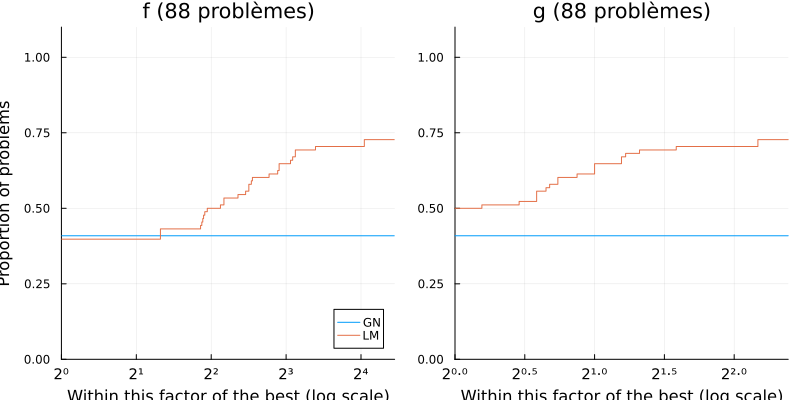

In [75]:
first_order(df) = df.status .== :first_order
unbounded(df) = df.status .== :unbounded
solved(df) = first_order(df) .| unbounded(df)
costnames = ["f (88 problèmes)", "g (88 problèmes)"]
costs = [
  df -> .!solved(df) .* Inf .+ df.neval_residual,
  df -> .!solved(df) .* Inf .+ df.neval_jac_residual,
]

using Plots
gr()

profile_solvers(stats, costs, costnames)

Le problème clplatec n'est pas résolu par les algorithmes (status = max_eval)

## Question 4

In [78]:
using JuMP, Ipopt

# Create JuMP model, using Ipopt as the solver
rocket = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level" => 0))

# Constants
# Note that all parameters in the model have been normalized
# to be dimensionless. See the COPS3 paper for more info.
h_0 = 1    # Initial height
v_0 = 0    # Initial velocity
m_0 = 1    # Initial mass
g_0 = 1    # Gravity at the surface

T_c = 3.5  # Used for thrust
h_c = 500  # Used for drag
v_c = 620  # Used for drag
m_c = 0.6  # Fraction of initial mass left at end

c     = 0.5 * sqrt(g_0 * h_0)  # Thrust-to-fuel mass
m_f   = m_c * m_0            # Final mass
D_c   = 0.5 * v_c * m_0 / g_0    # Drag scaling
T_max = T_c * g_0 * m_0        # Maximum thrust

n = 800   # Time steps

@variables(rocket, begin
    Δt ≥ 0, (start = 1/n) # Time step
    # State variables
    v[1:n] ≥ 0            # Velocity
    h[1:n] ≥ h_0          # Height
    m_f ≤ m[1:n] ≤ m_0    # Mass
    # Control
    0 ≤ T[1:n] ≤ T_max    # Thrust
end)

# Objective: maximize altitude at end of time of flight
@objective(rocket, Max, h[n])

# Initial conditions
@constraints(rocket, begin
    v[1] == v_0
    h[1] == h_0
    m[1] == m_0
    m[n] == m_f
end)

# Forces
# Drag(h,v) = Dc v^2 exp( -hc * (h - h0) / h0 )
@NLexpression(rocket, drag[j = 1:n], D_c * (v[j]^2) * exp(-h_c * (h[j] - h_0) / h_0))
# Grav(h)   = go * (h0 / h)^2
@NLexpression(rocket, grav[j = 1:n], g_0 * (h_0 / h[j])^2)
# Time of flight
@NLexpression(rocket, t_f, Δt * n)

# Dynamics
for j in 2:n
    # h' = v
    
    # Rectangular integration
    # @NLconstraint(rocket, h[j] == h[j - 1] + Δt * v[j - 1])
    
    # Trapezoidal integration
    @NLconstraint(rocket,
        h[j] == h[j - 1] + 0.5 * Δt * (v[j] + v[j - 1]))

    # v' = (T-D(h,v))/m - g(h)
    
    # Rectangular integration
    # @NLconstraint(rocket, v[j] == v[j - 1] + Δt *(
    #                 (T[j - 1] - drag[j - 1]) / m[j - 1] - grav[j - 1]))
    
    # Trapezoidal integration
    @NLconstraint(rocket,
        v[j] == v[j-1] + 0.5 * Δt * (
            (T[j] - drag[j] - m[j] * grav[j]) / m[j] +
            (T[j - 1] - drag[j - 1] - m[j - 1] * grav[j - 1]) / m[j - 1]))

    # m' = -T/c

    # Rectangular integration
    # @NLconstraint(rocket, m[j] == m[j - 1] - Δt * T[j - 1] / c)
    
    # Trapezoidal integration
    @NLconstraint(rocket,
        m[j] == m[j - 1] - 0.5 * Δt * (T[j] + T[j-1]) / c)
end

In [79]:
# Solve for the control and state
println("Solving...")
status = optimize!(rocket)

# Display results
# println("Solver status: ", status)
println("Max height: ", objective_value(rocket))

In [80]:
value.(h)[n]

1.0128340648308065

In [90]:
# Can visualize the state and control variables
using Gadfly: plot as plot

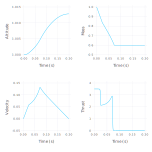

In [91]:
h_plot = plot(x = (1:n) * value.(Δt), y = value.(h)[:], Geom.line,
                Guide.xlabel("Time (s)"), Guide.ylabel("Altitude"))
m_plot = plot(x = (1:n) * value.(Δt), y = value.(m)[:], Geom.line,
                Guide.xlabel("Time (s)"), Guide.ylabel("Mass"))
v_plot = plot(x = (1:n) * value.(Δt), y = value.(v)[:], Geom.line,
                Guide.xlabel("Time (s)"), Guide.ylabel("Velocity"))
T_plot = plot(x = (1:n) * value.(Δt), y = value.(T)[:], Geom.line,
                Guide.xlabel("Time (s)"), Guide.ylabel("Thrust"))
draw(SVG(6inch, 6inch), vstack(hstack(h_plot, m_plot), hstack(v_plot, T_plot)))

### Questions:     
    - i) Transformer le modèle JuMP utilisé ci-dessus en un NLPModel en utilisant le package `NLPModelsJuMP`.    
    - ii) Résoudre ce nouveau modèle avec `Ipopt` en utilisant `NLPModelsIpopt`.    
    - iii) Calcul séparément la différence entre les h,v,m,T, Δt calculés.    
    - iv) Est-ce que le contrôle T atteint ses bornes ?    
    - v) Reproduire les graphiques ci-dessous avec la solution calculée via `NLPModelsIpopt`.

In [92]:
using NLPModels, LinearAlgebra, NLPModelsJuMP, NLPModelsIpopt

NLP_rocket = MathOptNLPModel(rocket)
stats = ipopt(NLP_rocket)

"Execution stats: first-order stationary"

In [93]:
Δt_nlp = stats.solution[1];
v_nlp = stats.solution[2:801];
h_nlp = stats.solution[802:1601];
m_nlp = stats.solution[1602:2401];
T_nlp = stats.solution[2402:3201];

Δv = maximum(value.(v)[:] - v_nlp)
Δh = maximum(value.(h)[:] - h_nlp)
Δm = maximum(value.(m)[:] - m_nlp)
ΔT = maximum(value.(T)[:] - T_nlp)

print(Δv, Δh, Δm, ΔT)

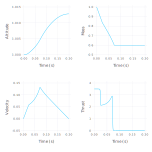

In [94]:
h_plot_nlp = plot(x = (1:n) * Δt_nlp, y = h_nlp, Geom.line,
                Guide.xlabel("Time (s)"), Guide.ylabel("Altitude"))
m_plot_nlp = plot(x = (1:n) * Δt_nlp, y = m_nlp, Geom.line,
                Guide.xlabel("Time (s)"), Guide.ylabel("Mass"))
v_plot_nlp = plot(x = (1:n) * Δt_nlp, y = v_nlp, Geom.line,
                Guide.xlabel("Time (s)"), Guide.ylabel("Velocity"))
T_plot_nlp = plot(x = (1:n) * Δt_nlp, y = T_nlp, Geom.line,
                Guide.xlabel("Time (s)"), Guide.ylabel("Thrust"))
draw(SVG(6inch, 6inch), vstack(hstack(h_plot_nlp, m_plot_nlp), hstack(v_plot_nlp, T_plot_nlp)))